<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Buddhika/Research_IT22564122_Hybrid_Model_New(MobileNetV2%2C_DenseNet121).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow scikit-learn opencv-python matplotlib seaborn


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


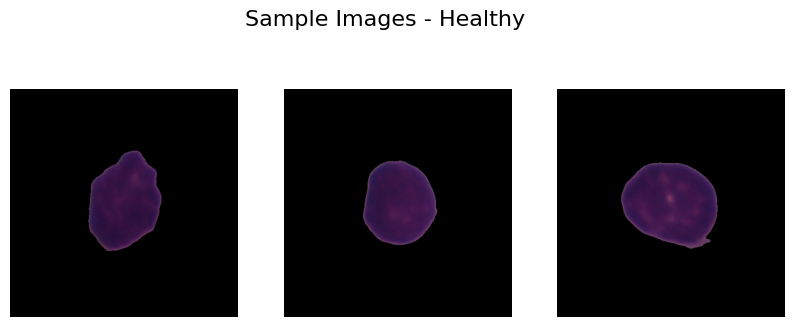

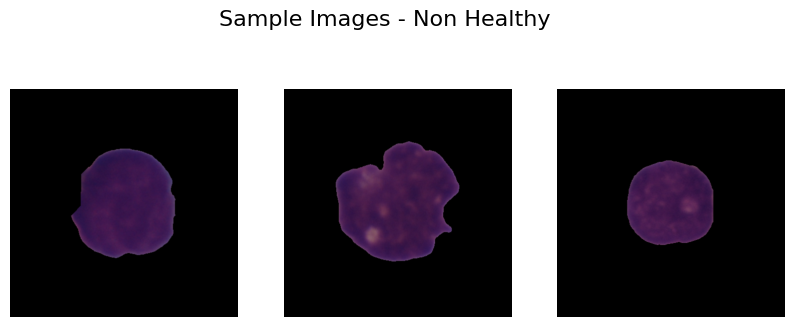

In [21]:
from PIL import Image

path = '/content/drive/MyDrive/New folder'
classes = ['Healthy', 'Non Healthy']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'Sample Images - {cat}', fontsize=16)

    for i in range(3):
        img = np.array(Image.open(os.path.join(image_dir, images[np.random.randint(len(images))])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 20
DATASET_PATH = "/content/drive/MyDrive/New folder"
CLASSES = ["Healthy", "Non Healthy"]


In [7]:
def load_images(path):
    X, y = [], []

    for label, cls in enumerate(CLASSES):
        cls_path = os.path.join(path, cls)
        for file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

X, y = load_images(DATASET_PATH)

y_cat = keras.utils.to_categorical(y, num_classes=2)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)


In [9]:
X_train_mob = mobilenet_preprocess(X_train.astype("float32"))
X_val_mob   = mobilenet_preprocess(X_val.astype("float32"))

X_train_den = densenet_preprocess(X_train.astype("float32"))
X_val_den   = densenet_preprocess(X_val.astype("float32"))


In [10]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))


In [11]:
# -------- MobileNetV2 Backbone --------
input_mob = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=input_mob
)
x1 = layers.GlobalAveragePooling2D()(mobilenet.output)
x1 = layers.BatchNormalization()(x1)

# -------- DenseNet121 Backbone --------
input_den = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
densenet = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_tensor=input_den
)
x2 = layers.GlobalAveragePooling2D()(densenet.output)
x2 = layers.BatchNormalization()(x2)

# -------- Feature Fusion --------
combined = layers.Concatenate()([x1, x2])
combined = layers.Dense(512, activation='relu')(combined)
combined = layers.BatchNormalization()(combined)
combined = layers.Dropout(0.5)(combined)

combined = layers.Dense(128, activation='relu')(combined)
combined = layers.BatchNormalization()(combined)
combined = layers.Dropout(0.3)(combined)

output = layers.Dense(2, activation='softmax')(combined)

model = keras.Model(inputs=[input_mob, input_den], outputs=output)


/tmp/ipython-input-223695043.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
for layer in mobilenet.layers:
    layer.trainable = False

for layer in densenet.layers:
    layer.trainable = False


In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)


In [14]:
history1 = model.fit(
    [X_train_mob, X_train_den], y_train,
    validation_data=([X_val_mob, X_val_den], y_val),
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.6184 - auc: 0.6617 - loss: 0.9339 - precision: 0.6184 - recall: 0.6184 - val_accuracy: 0.6762 - val_auc: 0.7301 - val_loss: 0.6130 - val_precision: 0.6762 - val_recall: 0.6762
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7759 - auc: 0.8411 - loss: 0.6166 - precision: 0.7759 - recall: 0.7759 - val_accuracy: 0.7286 - val_auc: 0.7932 - val_loss: 0.5605 - val_precision: 0.7286 - val_recall: 0.7286
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7618 - auc: 0.8313 - loss: 0.5995 - precision: 0.7618 - recall: 0.7618 - val_accuracy: 0.7476 - val_auc: 0.8380 - val_loss: 0.5266 - val_precision: 0.7476 - val_recall: 0.7476
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7928 - auc: 0.8707 - loss: 0.4871 - precision: 0.7928 - recall: 0.7928 - val_accuracy: 0.7857 - val_auc: 0.8616 - val_loss: 0.4918 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━

In [15]:
for layer in mobilenet.layers[-30:]:
    layer.trainable = True

for layer in densenet.layers[-30:]:
    layer.trainable = True


In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)


In [17]:
history2 = model.fit(
    [X_train_mob, X_train_den], y_train,
    validation_data=([X_val_mob, X_val_den], y_val),
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    class_weight=class_weights
)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7160 - auc: 0.7994 - loss: 0.6206 - precision: 0.7160 - recall: 0.7160 - val_accuracy: 0.7810 - val_auc: 0.8602 - val_loss: 0.5197 - val_precision: 0.7810 - val_recall: 0.7810
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7632 - auc: 0.8420 - loss: 0.5617 - precision: 0.7632 - recall: 0.7632 - val_accuracy: 0.7571 - val_auc: 0.8500 - val_loss: 0.5386 - val_precision: 0.7571 - val_recall: 0.7571
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.8014 - auc: 0.8887 - loss: 0.4617 - precision: 0.8014 - recall: 0.8014 - val_accuracy: 0.7619 - val_auc: 0.8481 - val_loss: 0.5349 - val_precision: 0.7619 - val_recall: 0.7619
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7731 - auc: 0.8645 - loss: 0.5423 - precision: 0.7731 - recall: 0.7731 - val_accuracy: 0.7857 - val_auc: 0.8521 - val_loss: 0.5250 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━

In [18]:
y_pred = model.predict([X_val_mob, X_val_den])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(
    y_true, y_pred_cls,
    target_names=CLASSES,
    digits=4
))


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step
              precision    recall  f1-score   support

     Healthy     0.8764    0.7358    0.8000       106
 Non Healthy     0.7686    0.8942    0.8267       104

    accuracy                         0.8143       210
   macro avg     0.8225    0.8150    0.8133       210
weighted avg     0.8230    0.8143    0.8132       210



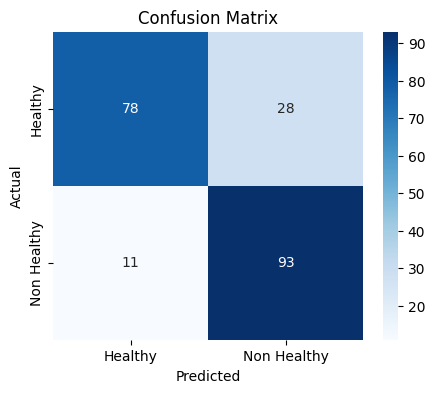

In [19]:
cm = confusion_matrix(y_true, y_pred_cls)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASSES,
            yticklabels=CLASSES,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


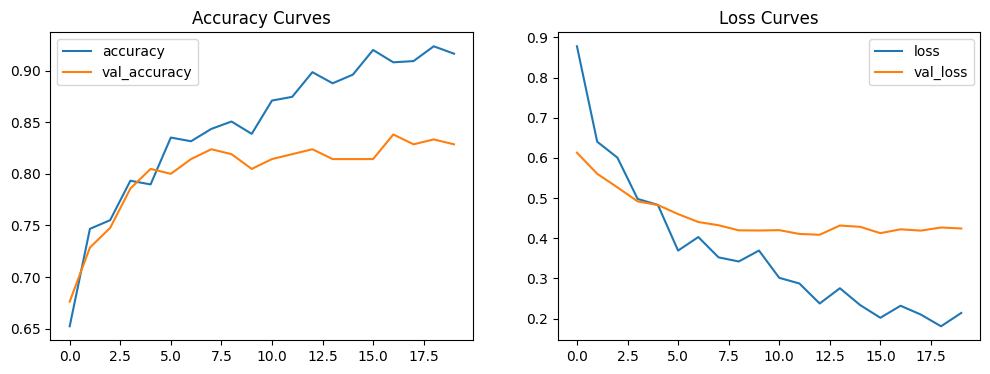

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


Text(0.5, 1.0, 'Confusion Matrix')

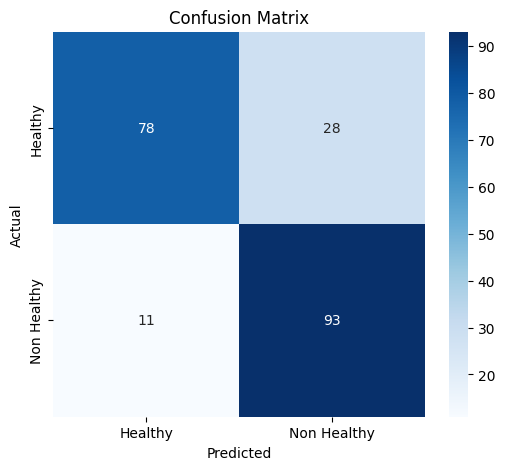

In [23]:
import pandas as pd

# Plot Accuracy and Loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
history_df = pd.DataFrame(history1.history)

history_df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
ax[0].set_title('Accuracy Curves')

history_df[['loss', 'val_loss']].plot(ax=ax[1])
ax[1].set_title('Loss Curves')
plt.show()

# Confusion Matrix
Y_pred = model.predict([X_val_mob, X_val_den])
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [24]:
model_path="/content/drive/MyDrive/New folder/Hybrid_Model_new(MobileNetV2,_DenseNet121).keras"
model.save(model_path)
